In [1]:
import sys
import pandas as pd
import numpy as np
import re
import pickle
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, KernelPCA
from collections import Counter
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import precision_score, recall_score, f1_score, r2_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import learning_curve
from sklearn.base import clone
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from itertools import combinations
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.stats import mannwhitneyu, shapiro, probplot
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
!pip install catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor

     |████████████████████████████████| 67.4 MB 26 kB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Описание датасета

Home Ownership - домовладение<br>
Annual Income - годовой доход<br>
Years in current job - количество лет на текущем месте работы<br>
Tax Liens - налоговые обременения<br>
Number of Open Accounts - количество открытых счетов<br>
Years of Credit History - количество лет кредитной истории<br>
Maximum Open Credit - наибольший открытый кредит<br>
Number of Credit Problems - количество проблем с кредитом<br>
Months since last delinquent - количество месяцев с последней просрочки платежа<br>
Bankruptcies - банкротства<br>
Purpose - цель кредита<br>
Term - срок кредита<br>
Current Loan Amount - текущая сумма кредита<br>
Current Credit Balance - текущий кредитный баланс<br>
Monthly Debt - ежемесячный долг<br>
Credit Score - кредитный рейтинг <br>
Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [4]:
train_path = '/content/drive/My Drive/data/default_set/train.csv'
test_path = '/content/drive/My Drive/data/default_set/test.csv'

In [5]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [10]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [11]:
test_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [12]:
train_df.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0


In [13]:
test_df.tail(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


Поиск выбросов и аномалий

In [14]:
for col in train_df.columns[:-1].to_list():
    print(train_df[col].value_counts())

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
1141254.0    1
7907382.0    1
1534478.0    1
972040.0     1
1654786.0    1
Name: Annual Income, Length: 5478, dtype: int64
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64
9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14

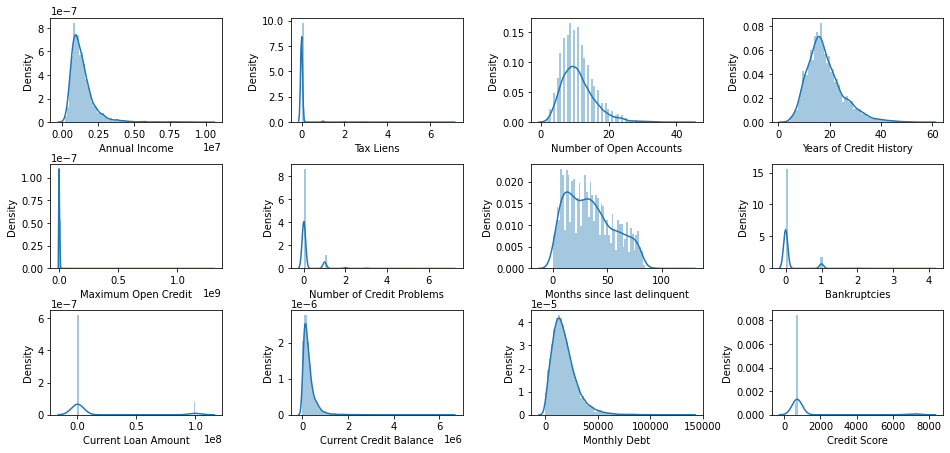

In [8]:
"""
fig, ax = plt.subplots(3, 4, figsize=(16, 10))
ax = ax.flatten()
for axis, column in zip(ax, train_df.select_dtypes(['float', 'int']).columns[:-1]):
  axis.set_title(f'{column}')
  axis.hist(train_df[column], bins=60)
plt.show()
"""
plt.figure(figsize=(16, 10))
numeric_cols = train_df.select_dtypes(['float', 'int']).columns[:-1]
for idx, col in enumerate(numeric_cols):
    plt.subplot(4, 4, idx + 1)
    sns.distplot(train_df[col], bins=70)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

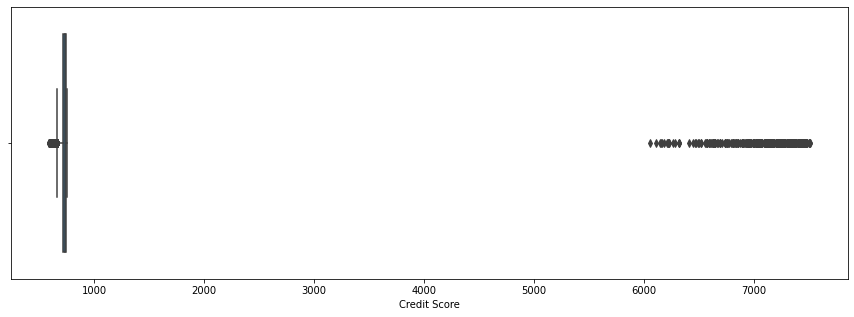

In [40]:
plt.figure(figsize=(15, 5))
sns.boxplot(train_df['Credit Score'])
plt.show()

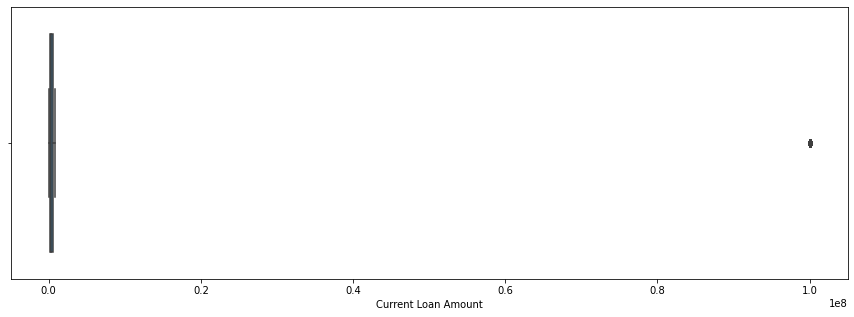

In [41]:
plt.figure(figsize=(15, 5))
sns.boxplot(train_df['Current Loan Amount'])
plt.show()

Матрица корреляций
Теоретичкски можно избавиться от признаков с коррееляцией большей 0.66 - оставить один либо их скомбинировать

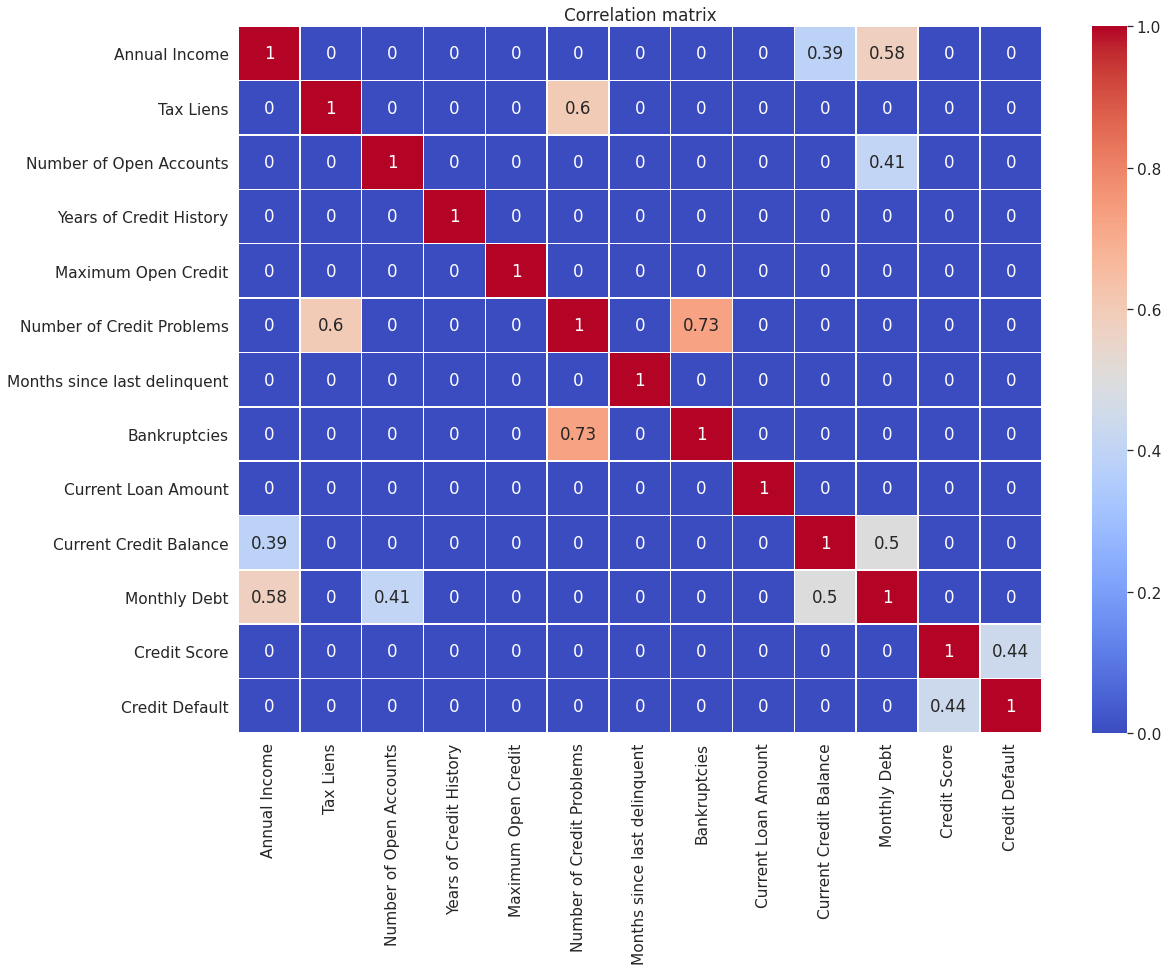

In [42]:
plt.figure(figsize = (18,13))
sns.set(font_scale=1.4)
corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

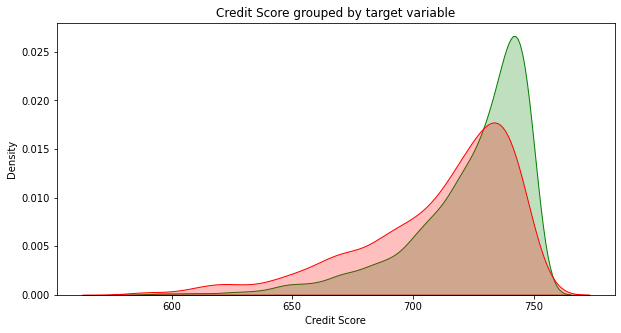

In [6]:
TARGET_NAME = 'Credit Default'
train_df.loc[train_df['Credit Score'] > 1000, 'Credit Score'] /= 10

feature_with_target_s = train_df[['Credit Score', TARGET_NAME]]
feature_s = feature_with_target_s['Credit Score']
feature_target_0 = feature_s[feature_with_target_s[TARGET_NAME] == 0]
feature_target_1 = feature_s[feature_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(feature_target_0, shade=True, label='No default', color='g')
sns.kdeplot(feature_target_1, shade=True, label='Default', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

In [19]:
shapiro(feature_s.dropna())

(0.8512157201766968, 0.0)

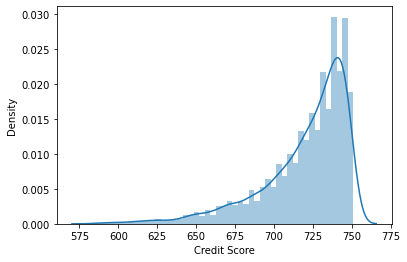

In [16]:
sns.distplot(train_df['Credit Score'])

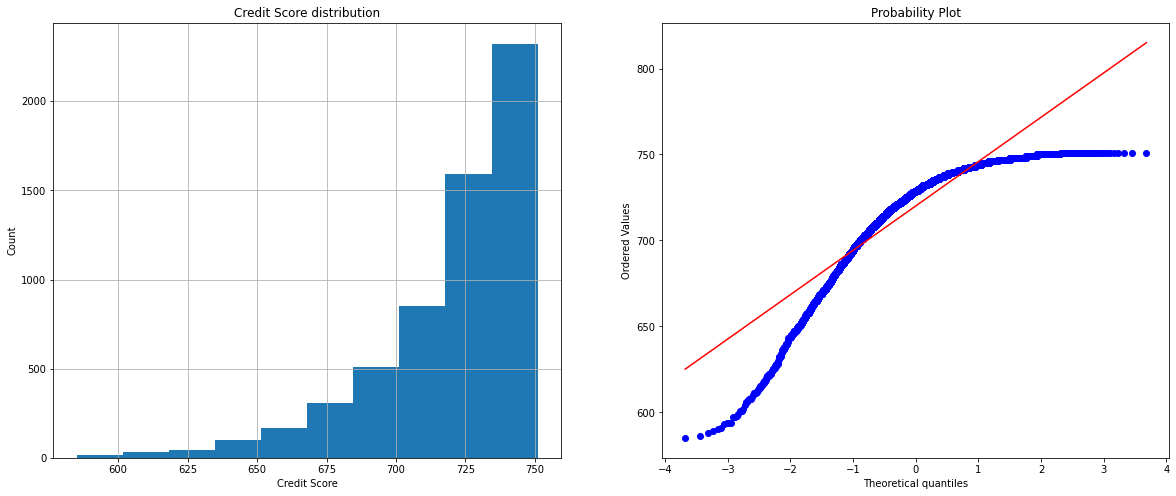

In [22]:
to_plot = train_df[['Credit Score', TARGET_NAME]].dropna()
to_plot1 = to_plot['Credit Score']
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
to_plot1.hist()

plt.subplot(122)
probplot(to_plot1, dist='norm', plot=plt)

plt.show()

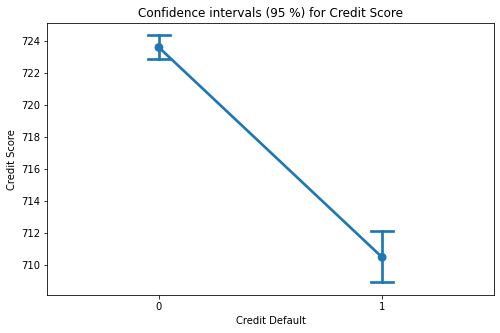

In [23]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=to_plot, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

In [20]:
# предполагая отсутстыие нормального распределения попробуем применить критерий Манна-Уитни
for idx, column in enumerate(train_df.select_dtypes(['float', 'int']).columns[:-1], 1):
  feature_with_target_s = train_df[[column, TARGET_NAME]] # без sample
  feature_s = feature_with_target_s[column]
  feature_target_0 = feature_s[feature_with_target_s[TARGET_NAME] == 0]
  feature_target_1 = feature_s[feature_with_target_s[TARGET_NAME] == 1]
  mw = mannwhitneyu(feature_target_0, feature_target_1)
  imp = np.where(mw.pvalue < 0.05, 'usefull', 'useless') 
  if imp == 'usefull' and shapiro(feature_s.dropna())[1] < 0.05:  
    print(f'{idx}) {column}, p-value: {mw.pvalue}, feature is {imp}')
  else:
    print('='*45)

1) Annual Income, p-value: 0.031334788783133206, feature is usefull
2) Tax Liens, p-value: 0.02256138327362573, feature is usefull
3) Number of Open Accounts, p-value: 0.003761646078803518, feature is usefull
4) Years of Credit History, p-value: 0.003171215731103466, feature is usefull
5) Maximum Open Credit, p-value: 2.3483604148529427e-08, feature is usefull
7) Months since last delinquent, p-value: 2.2303574646660457e-71, feature is usefull
9) Current Loan Amount, p-value: 2.923443678733522e-10, feature is usefull
11) Monthly Debt, p-value: 0.03183394406726229, feature is usefull
12) Credit Score, p-value: 1.9026355001093805e-13, feature is usefull


In [11]:
train_df[TARGET_NAME].value_counts(normalize=True) # дисбаланс классов

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

In [7]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
def cross_validation(clf, X, y):
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring='f1', n_jobs=-1)
    print(f'Меры правильности перекрекстной оценки: {scores}')
    print(f'Точность перекретсной оценки: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

def plot_cm_val(y_true, y_pred, X, y, estimator):
  cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
  conf_df = pd.DataFrame(cm, index=[0,1], columns=[0,1])
  scores = np.array(cross_validation(estimator, X, y))
  print('\n')
  plt.figure(figsize=(16,6))
  plt.subplot(121)
  sns.heatmap(conf_df, cmap="Oranges", annot=True, annot_kws={"size": 16}, fmt='d')
  plt.title('Confusion matrix for test')
  plt.ylabel('True')
  plt.xlabel('Predicted')
  plt.subplot(122)
  plt.plot(scores, c='g', linestyle=':', label='Cross Validation Scores', marker='*')
  plt.fill_between(np.arange(scores.shape[0]), scores.mean() - scores.std(), scores.mean() + scores.std(), alpha=0.3)
  plt.axhline(0.5, c='r', linestyle='--', label='min f1_score')
  plt.axhline(scores.mean(), c='b', linestyle='-.', label='score mean')
  plt.legend(loc='best')
  plt.ylim([0.47, max(scores) + 0.1])
  plt.xticks(np.arange(scores.shape[0]))
  plt.grid()
  plt.show()

def report(y_train, y_train_pred, y_test, y_test_pred):
  print('Train\n', classification_report(y_train, y_train_pred, digits=3))
  print('Test\n', classification_report(y_test, y_test_pred, digits=3))
  roc_train, roc_test = roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)
  print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}') # weighted?
  print(f'Train GINI: {(2 * roc_train - 1):.3f}, Test GINI: {(2 * roc_test - 1):.3f}')
  print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))

def custom_oversampling(df, target_name=TARGET_NAME):
  target_counts = df[target_name].value_counts()
  major_class_name = target_counts.argmax()
  minor_clss_name = target_counts.argmin()
  disbalance_coef = int(target_counts[major_class_name] / target_counts[minor_clss_name]) - 1
  for i in range(disbalance_coef):
    sample = df[df[target_name] == minor_clss_name].sample(target_counts[minor_clss_name])
    df = df.append(sample, ignore_index=True)
  return df.sample(frac=1)

def vote(predictions: list, weights: list):
  predictions = np.asarray(predictions).T
  maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=weights)), axis=1, arr=predictions)
  return maj_vote


In [8]:
class CatPreprocessor:

    def __init__(self, with_cat=False, target='Credit Default'):
        self.target = target
        self.medians = None
        self.means = None
        self.modes = None
        self.stds = None
        self.regressor_annual = CatBoostRegressor(eval_metric='R2', silent=True, one_hot_max_size=15,
                                                  early_stopping_rounds=20, boosting_type='Ordered', # round 20
                                                  allow_writing_files=False, depth=6, iterations=800, # 6, 400 (800)
                                                  learning_rate=0.05, l2_leaf_reg=1., random_seed=1) # 0.05, 1.                                                 
        self.regressor_cs = CatBoostRegressor(eval_metric='R2', silent=True, one_hot_max_size=15,
                                              early_stopping_rounds=40, boosting_type='Ordered',
                                              allow_writing_files=False, depth=5, iterations=400,
                                              learning_rate=0.03, l2_leaf_reg=2, random_seed=1)
        self.pca = PCA(n_components=1, random_state=1)
        self.scaler = RobustScaler(with_centering=False)
        self.purpose_dict = None
        self.scaler_cl = StandardScaler()
        self.kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=1, tol=1e-04)
        self.bins_annual = None
        self.bins_loan = None
        self.bins_cs = None
        self.years_probas = None
        self.median_label = None #
        self.temp_df = None #
        self.num_acc = None #
        self.with_cat = with_cat
        self.lda = LDA()
        self.k_pca_scaler = StandardScaler()
        self.k_pca = KernelPCA(n_components=1, kernel='rbf', gamma=1.5e-2, eigen_solver='arpack', random_state=1, 
                               n_jobs=-1)
        self.indices = None
        self.iso = IsolationForest(n_estimators=100, contamination=0.001, n_jobs=-1, random_state=1) # можно также использовать кластеризацию 
    
    def fit(self, df):
        self.medians = df.median()
        self.means = df.mean()
        self.modes = df.mode()
        self.stds = df.std()
        self.purpose_dict = df.groupby(by='Purpose')['Current Loan Amount'].agg({'median'}).to_dict()['median']
        self.bins_annual = [*np.arange(1e+5, 2e+6, 1e+5), df['Annual Income'].max()]
        self.bins_loan = [*np.arange(1e+4, 6e+6, 2e+5), df['Current Loan Amount'].max()]
        self.bins_cs = [*np.linspace(585., 751., 15)]
        self.years_probas = df['Years in current job'].value_counts().apply(lambda x: x / df[~df['Years in current job'].isnull()].shape[0]).to_list()
        self.num_acc = df.groupby(by='Number of Open Accounts')['Maximum Open Credit'].agg('median').to_dict()
    
    def _fill_annual(self, df):
        annual_to_fill = df[df['AI_NA'] == 1].drop(['Annual Income', 'AI_NA', 'CS_NA'], axis=1)
        if self.target in df.columns:
          annual_train = df[df['AI_NA'] == 0].drop(['Annual Income', self.target, 'AI_NA', 'CS_NA'], axis=1)
          feature_cat_to_train = annual_train.select_dtypes(['object', 'int']).columns.to_list()
          annual_target = df.loc[df['AI_NA'] == 0, 'Annual Income']
          X_train, X_test, y_train, y_test = train_test_split(annual_train, annual_target, test_size=0.33, 
                                                              shuffle=True, random_state=1)
          train_pool, test_pool = Pool(X_train, y_train, cat_features=feature_cat_to_train), Pool(X_test, y_test, cat_features=feature_cat_to_train)
          self.regressor_annual.fit(train_pool, eval_set=test_pool)
          print(f'Score R2 [Annual Income]: {self.regressor_annual.get_best_score()}')
        # predict NaN values in df
          df.loc[df['AI_NA'] == 1, 'Annual Income'] = self.regressor_annual.predict(annual_to_fill.drop(self.target, axis=1))
          del annual_train        
        else: 
          df.loc[df['AI_NA'] == 1, 'Annual Income'] = self.regressor_annual.predict(annual_to_fill)
        del annual_to_fill
        return df

    def _fill_cs(self, df):
        cs_to_fill = df[df['CS_NA'] == 1].drop(['Credit Score', 'AI_NA', 'CS_NA'], axis=1)
        if self.target in df.columns:
          cs_train = df[df['CS_NA'] == 0].drop(['Credit Score', self.target, 'AI_NA', 'CS_NA'], axis=1)
          feature_cat_to_train = cs_train.select_dtypes(['object', 'int']).columns.to_list()
          cs_target = df.loc[df['CS_NA'] == 0, 'Credit Score']
          X_train, X_test, y_train, y_test = train_test_split(cs_train, cs_target, test_size=0.33, 
                                                              shuffle=True, random_state=1)
          train_pool, test_pool = Pool(X_train, y_train, cat_features=feature_cat_to_train), Pool(X_test, y_test, cat_features=feature_cat_to_train)
          self.regressor_cs.fit(train_pool, eval_set=test_pool)
          print(f'Score R2 [Credit Score]: {self.regressor_cs.get_best_score()}')
        # predict NaN values in df
          df.loc[df['CS_NA'] == 1, 'Credit Score'] = self.regressor_cs.predict(cs_to_fill.drop(self.target, axis=1))
          del cs_train        
        else: 
          df.loc[df['CS_NA'] == 1, 'Credit Score'] = self.regressor_cs.predict(cs_to_fill)
        del cs_to_fill
        return df
        
    def transform(self, df, pca=False):
        # признак категоризирующий наличие выбросов
        df['isSusp'] = '0'
        df.loc[df['Years of Credit History'] > 50, 'isSusp'] = '1'
        df.loc[df['Credit Score'] > 1000, 'isSusp'] = '1'
        df.loc[df['Current Loan Amount'] > 0.8e+8, 'isSusp'] = '2'

        # experimental, nans в Annual income и Credit Score в одних строках
        df['isNa'] = '0'
        df.loc[df['Annual Income'].isnull(), 'isNa'] = '1'
        df.loc[df['Years in current job'].isnull(), 'isNa'] = '2'
        """
        можно не использовать данный признак, на на кросс-валидации получил более устойчивый результат, с чуть более низкой метрикой
        Annual Income
        Years in current job
        Months since last delinquent
        Bankruptcies
        Credit Score
        """
        # устранение выбросов в Credit Score, похоже их просто случайно умножили на 10
        
        df.loc[df['Credit Score'] > 1000, 'Credit Score'] /= 10.
        # выбор random возможно не лучшая идея, может добавиться "шум" в данных
        
        loan_condition = ((df['Current Loan Amount'] > 0.8e+8) & (df['Term'] == 'Short Term') & (df['Monthly Debt'].between(5000, 100000)))
        df.loc[loan_condition, 'Current Loan Amount'] = 12 * np.random.uniform(low=0.1, high=1, 
                                                                               size=df[loan_condition].shape[0]) * \
                                                                                    df.loc[loan_condition, 'Monthly Debt']
        loan_condition = ((df['Current Loan Amount'] > 0.8e+8) & (df['Term'] == 'Long Term') & (df['Monthly Debt'].between(5000, 100000)))
        df.loc[loan_condition, 'Current Loan Amount'] = 12 * np.random.uniform(low=1.5, high=15, 
                                                                              size=df[loan_condition].shape[0]) * \
                                                                                   df.loc[loan_condition , 'Monthly Debt']
        
        df.loc[(df['Current Loan Amount'] > 0.8e+8), 'Current Loan Amount'] = self.medians['Current Loan Amount']
        
        # выбросы в годах кредитной истории
        df.loc[df['Years of Credit History'] > 50, 'Years of Credit History'] = np.quantile(df['Years of Credit History'], q=0.95)
        
        # устранение пропусков в доходе
        df['AI_NA'] = 0
        df.loc[df['Annual Income'].isnull(), 'AI_NA'] = 1
        df.loc[df['Annual Income'].isnull(), 'Annual Income'] = \
                                    np.random.uniform(low=(self.means['Annual Income'] - self.stds['Annual Income']),
                                                      high=(self.means['Annual Income'] + self.stds['Annual Income']),
                                                      size=int(df['Annual Income'].isnull().sum()))
        # заполнение пропусков в Credit Score
        df['CS_NA'] = 0
        df.loc[df['Credit Score'].isnull(), 'CS_NA'] = 1
        df.loc[(df['Credit Score'].isnull()), 'Credit Score'] = \
                                np.random.uniform(low=df['Credit Score'].mean() - df['Credit Score'].std(),
                                                  high=df['Credit Score'].mean() + df['Credit Score'].std(),
                                                  size=df[df['Credit Score'].isnull()].shape[0])       
        
        # пропуски в years in current job, Bankruptcies
        if not self.with_cat:
          # df['Years in current job'].fillna(self.modes['Years in current job'][0], inplace=True)
          # более разумная, на первый взгляд операция, снижает точность модели при кросс-валидации
          
          df.loc[df['Years in current job'].isnull(), 'Years in current job'] = \
            np.random.choice(df['Years in current job'].dropna(axis=0).unique(), p=self.years_probas, size=df[df['Years in current job'].isnull()].shape[0])
          
        else:
          df['Years in current job'].fillna('unk', inplace=True)
        df['Bankruptcies'].fillna(self.modes['Bankruptcies'][0], inplace=True)
        
        # пропуски в Months since last delinquent
        
        deliquent_condition = ((df['Months since last delinquent'].isnull()) & 
                               (df['Number of Credit Problems'] == 0) & (df['Bankruptcies'] == 0))
        df.loc[deliquent_condition, 'Months since last delinquent'] = 0
        df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = \
                        np.random.randint(low=(self.means['Months since last delinquent'] - 
                                               self.stds['Months since last delinquent']),
                                          high=(self.means['Months since last delinquent'] + 
                                                self.stds['Months since last delinquent']),
                                          size=int(df['Months since last delinquent'].isnull().sum()))
        
        # выброс Monthly Debt, так как все Short Term
        df.loc[df['Monthly Debt'] == 0, 'Monthly Debt'] = df.loc[df['Monthly Debt'] == 0, 'Current Loan Amount'] / 12.

        # если остались пропуски
        df.fillna(self.medians, inplace=True)

        # other object features
        if not self.with_cat:
          df['Years in current job'] = df['Years in current job'].apply(lambda x: re.search('\d+', x.replace('< 1', '0')).group(0)).astype(np.int8)
          df = self.dummies(df)   
          # Purpose to PCA / grouping
          if pca:
              df = pd.concat([df, pd.get_dummies(df['Purpose'])], axis=1)
              if self.target in df.columns:
                  df['Purpose'] = self.pca.fit_transform(self.scaler.fit_transform(df.iloc[:, -15:]))
              else:
                  df['Purpose'] = self.pca.transform(self.scaler.transform(df.iloc[:, -15:]))
              df = df.iloc[:, :-15]
          else:
              df['Purpose'] = df['Purpose'].map(self.purpose_dict)
          df['Purpose'] = df['Purpose'].astype(np.float32)

          df = pd.concat([df, pd.get_dummies(df['isSusp'], dtype=np.int8, prefix='isSusp')], axis=1)
          df.drop('isSusp', axis=1, inplace=True) 

          df = pd.concat([df, pd.get_dummies(df['isNa'], dtype=np.int8, prefix='isNa')], axis=1)
          df.drop('isNa', axis=1, inplace=True)          

        return df

    def dummies(self, df): # if not cat_features
        # dummies
        df = pd.concat([df, pd.get_dummies(df['Home Ownership'])], axis=1)
        df.drop('Home Ownership', axis=1, inplace=True)
        
        df = pd.concat([df, pd.get_dummies(df['Term'])], axis=1)
        df.drop('Term', axis=1, inplace=True)
        
        df.iloc[:, -6:] = df.iloc[:, -6:].astype(np.int8)

        return df
    
    def create_features(self, df, with_clusters=False, regr=True):

        # clustering # do not use clusters with with_cat=True
        if with_clusters:
            if self.target in df.columns:
                df['Cluster'] = self.kmeans.fit_predict(self.scaler_cl.fit_transform(df.select_dtypes(['float', 'int']).drop(self.target, axis=1)))
                #df['Cluster'] = self.kmeans.fit_predict(self.scaler_cl.fit_transform(df.drop(self.target, axis=1)))            
            else:
                df['Cluster'] = self.kmeans.predict(self.scaler_cl.transform(df.select_dtypes(['float', 'int'])))
                #df['Cluster'] = self.kmeans.predict(self.scaler_cl.transform(df))
            if not self.with_cat:
                df = pd.concat([df, pd.get_dummies(df['Cluster'], prefix='Cluster')], axis=1)
                df.drop('Cluster', axis=1, inplace=True)
                df.iloc[:, -5:] = df.iloc[:, -5:].astype(np.int8)
        
        # Ann_inc_cat, Cs_cat нужны для регрессии, т.к. имеют хорошую корреляцию с целевой (искомой) переменной, с помощью ChooseBestSubset можно решить нужны они далее или нет
        df['Ann_inc_cat'] = pd.cut(df['Annual Income'], bins=self.bins_annual, labels=False) 
        df['CurLoan_cat'] = pd.cut(df['Current Loan Amount'], bins=self.bins_loan, labels=False)
        df['CurLoan_cat'].fillna(df['CurLoan_cat'].mode()[0], inplace=True)
        df['Cs_cat'] = pd.cut(df['Credit Score'], bins=self.bins_cs, labels=False)
        df['Cs_cat'].fillna(df['Cs_cat'].mode()[0], inplace=True)
        df['Ann_inc_cat'].fillna(df['Ann_inc_cat'].median(), inplace=True)
        
        # попытка связать новую фичу с метками 
        if self.target in df.columns and not self.with_cat:
            self.df_temp = df.groupby(by=['isSusp_1', 'Cs_cat'], as_index=False).agg({self.target: 'count'})
            self.df_temp.columns = ['isSusp_1', 'Cs_cat', 'Label_cat']
            self.median_label = self.df_temp['Label_cat'].median()
        if not self.with_cat:
          df = df.merge(self.df_temp, on=['isSusp_1', 'Cs_cat'], how='left')
          df['Label_cat'].fillna(self.median_label, inplace=True)
         
        df['Max_Acc'] = df['Number of Open Accounts'].map(self.num_acc)
        df['Max_Acc'].fillna(df['Max_Acc'].median(), inplace=True)
        
        columns_to_int = ['CurLoan_cat', 'Ann_inc_cat', 'Cs_cat', 'Cluster'] if self.with_cat else ['Tax Liens', 'Bankruptcies', 
                                                                                                                 'Number of Credit Problems', 
                                                                                                                 'CurLoan_cat', 'Ann_inc_cat',
                                                                                                                 'Cs_cat', 'Label_cat']
        df[columns_to_int] = df[columns_to_int].astype(np.int8)

        # платежеспособность
        df['Month_ratio'] = df['Monthly Debt'] / df['Annual Income']

        if regr:
            df = self._fill_cs(df)
            df = self._fill_annual(df)
        df = df.drop(['AI_NA', 'CS_NA'], axis=1)

        if self.target in df.columns:
          credit = df[self.target].copy()
          df = df.drop(self.target, axis=1)
          df = pd.concat([df, credit], axis=1)
        else:
          if not self.with_cat:
            del self.temp_df
        
        return df

    def pca_lda_decomposition(self, df, n_components=1, reduced_features=10, pca_lda='pca'): # LDA will not return more n_class-1 feature
      self.lda.n_components = n_components
      if self.target in df.columns:
          rf_model = RandomForestClassifier(n_estimators=350, max_depth=5, criterion='entropy', 
                                            n_jobs=-1, random_state=1, class_weight='balanced', max_features=None)
          X, y = df.drop(self.target, axis=1), df[self.target]
          X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y,
                                                              random_state=1)
          rf_model.fit(X_train, y_train)
          print(f'Train f1: {f1_score(y_train, rf_model.predict(X_train)):.3f}, Test f1: {f1_score(y_test, rf_model.predict(X_test)):.3f}')
          importances = rf_model.feature_importances_
          self.indices = np.argsort(importances)[::-1]
          df_cols = np.array(df.columns[:-1])[self.indices[:-reduced_features]]
          lda_cols = np.array(df.columns[:-1])[self.indices[-reduced_features:]]
          target = df[self.target].copy()
          df_dec, lda_df = df[list(df_cols)], df[list(lda_cols)] 
          if pca_lda == 'lda':
            mod_df = pd.DataFrame(self.lda.fit_transform(self.k_pca_scaler.fit_transform(lda_df), target), columns=['LDA_f'])
          elif pca_lda == 'pca':
            mod_df = pd.DataFrame(self.k_pca.fit_transform(self.k_pca_scaler.fit_transform(lda_df)), columns=['KPCA_f'])
          else:
            raise ValueError(f'Модель понижения размерности должны быть pca или lda, дана {pca_lda}')
          df = pd.concat([df_dec, mod_df, target], axis=1)
          del target
      else:
          df_cols = np.array(df.columns)[self.indices[:-reduced_features]]
          lda_cols = np.array(df.columns)[self.indices[-reduced_features:]]
          df_dec, lda_df = df[list(df_cols)], df[list(lda_cols)]
          if pca_lda == 'lda': 
            mod_df = pd.DataFrame(self.lda.transform(self.k_pca_scaler.transform(lda_df)), columns=['LDA_f'])
          elif pca_lda == 'pca':
            mod_df = pd.DataFrame(self.k_pca.transform(self.k_pca_scaler.transform(lda_df)), columns=['KPCA_f'])            
          else:
            raise ValueError(f'Модель понижения размерности должны быть pca или lda, дана {pca_lda}')
          df = pd.concat([df_dec, mod_df], axis=1)

      del df_dec
      del lda_df
      del mod_df
      return df
    
    def __call__(self, df, decomposition=False, with_clusters=True, regr=True):
      if self.target in df.columns:
        self.fit(df)
      df = self.transform(df)
      df = self.create_features(df, with_clusters=with_clusters, regr=regr)
      if decomposition:
        df = self.pca_lda_decomposition(df, reduced_features=10, pca_lda='pca') # hard params
      df = self.reduce_memory(df)
      
      if not self.with_cat:
        if self.target in df.columns:
          outlier_left = self.iso.fit_predict(df.drop(self.target, axis=1))
        else:
          outlier_left = self.iso.predict(df)
      else:
        if self.target in df.columns:
          cat_cols = df.select_dtypes(['float32', 'float64']).columns
          outlier_left = self.iso.fit_predict(df.drop(self.target, axis=1)[cat_cols])
        else:
          cat_cols = df.select_dtypes(['float32', 'float64']).columns
          outlier_left = self.iso.predict(df[cat_cols])
      outliers_num = Counter(outlier_left)[-1]
      if outliers_num > 0:
        print(f'Possible {outliers_num} outliers left, check dataset or use outlier stable methods')
      else:
        print(f'Probably no outliers left in dataset')
      
      return df
    
    @staticmethod
    def sampling(df, method='smote'):
      X, y = df.drop('Credit Default', axis=1), df['Credit Default']
      columns = df.columns
      counts_start = Counter(y)
      print(f'Inintial class labels ratio: {dict(counts_start)}')
      if method == 'smote_under':
          over = SMOTE(sampling_strategy=0.45, random_state=1, k_neighbors=7, n_jobs=-1)
          under = RandomUnderSampler(sampling_strategy=0.5, random_state=1)
          X, y = over.fit_resample(X, y)
          X, y = under.fit_resample(X, y)
      elif method == 'svm':
          over = SVMSMOTE(sampling_strategy=0.9, random_state=1, n_jobs=-1) # sampling_strategy='auto' - not majority, здесь подходит - 2 метки
          X, y = over.fit_resample(X, y)
      elif method == 'smote':
          over = SMOTE(sampling_strategy=0.8, random_state=1)
          X, y = over.fit_resample(X, y)
      elif method == 'ada':
          over = ADASYN(sampling_strategy=0.7, random_state=1, n_jobs=-1)
          X, y = over.fit_resample(X, y)
      else: 
          raise ValueError(f'Method should be "smote", "svm" or "ada", given: {method}')
      counts_end = Counter(y)
      print(f'Final class labels ratio: {dict(counts_end)}')
      return X, y

    @staticmethod
    def reduce_memory(df):
        start_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
        for col in df.columns:
            col_type = df[col].dtype
            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')
        end_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))   
        return df    

In [9]:
# класс, который выбирает наилучший поднабор признаков, исходя из заданной метрики
class ChooseBestSubset:
    def __init__(self, estimator, k_features, scoring='f1_score', test_size=0.25, random_state=1, method='svm', 
                 custom=True):
        self.scoring = str(scoring)
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        self.method = method
        self.custom = custom
        if (self.scoring == 'f1_score') or (self.scoring == 'accuracy_score'):
            self.scoring = eval(self.scoring)
        else:
            raise ValueError(f'Метрика должна быть "f1_score" или "accuracy_score", дана: {self.scoring}')
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, stratify=y, shuffle=True,
                                                           random_state=self.random_state)
        try:
            if not self.custom:
                df_to_train = pd.DataFrame(np.vstack((X_train.T, y_train)).transpose(1,0), columns=train_df.columns)
                X_train, y_train = preprocessor.sampling(df_to_train, method=self.method)
            else:
                X_train = custom_oversampling(pd.concat([X_train, y_train], axis=1))
                y_train = X_train[TARGET_NAME]
                X_train.drop(TARGET_NAME, axis=1, inplace=True)
        except Exception:
            sys.stderr.write(f'Невозможно произвести сэмплирование.')
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_) # сначала для полного набора
        self.scores_ = [score]
        while dim > self.k_features: # цикл до тех пор, пока не будет наименее короткий заданный набор
            scores, subsets = [], []
            sys.stderr.write(f'Анализ наборов признаков {dim}/{X_train.shape[1]}, осталось {dim - self.k_features}:')
            for p in tqdm(combinations(self.indices_, r=dim-1), total=dim): # проверяем различные комбинации признаков 
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score) # записываем score текущего набора
                subsets.append(p) # записываем значения индексов текущего набора
            clear_output(wait=True)
            best = np.argmax(scores) # находим лучший набор
            self.indices_ = subsets[best] # сохраняем значения индексов лучшего набора из текущей итерации while
            self.subsets_.append(self.indices_) # сохраняем лучший набор из текущей итерации while
            dim -= 1
            self.scores_.append(scores[best]) # сохраняем лучшее значение метрики на текущей итерации
        self.k_score_ = self.scores_[-1] # scores для последнего набора = k_features
        return self
    def _calc_score(self, X_train, y_train, X_test, y_test, indices): # вычисляем метрику набора
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [10]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
preprocessor = CatPreprocessor(with_cat=False)
train_df = preprocessor(train_df)
test_df = preprocessor(test_df)

Score R2 [Credit Score]: {'learn': {'R2': 0.9785919873129557, 'RMSE': 4.079446941511274}, 'validation': {'R2': 0.9852317816597717, 'RMSE': 3.4150528247384395}}
Score R2 [Annual Income]: {'learn': {'R2': 0.992072693361915, 'RMSE': 72945.21965203971}, 'validation': {'R2': 0.9572711027096503, 'RMSE': 185145.28289511966}}
Memory usage of dataframe is 0.94 MB
Memory usage after optimization is: 0.58 MB
Decreased by 38.6%
Possible 8 outliers left, check dataset or use outlier stable methods
Memory usage of dataframe is 0.30 MB
Memory usage after optimization is: 0.19 MB
Decreased by 35.5%
Possible 4 outliers left, check dataset or use outlier stable methods


In [11]:
X, y = train_df.drop(TARGET_NAME, axis=1), train_df[TARGET_NAME]

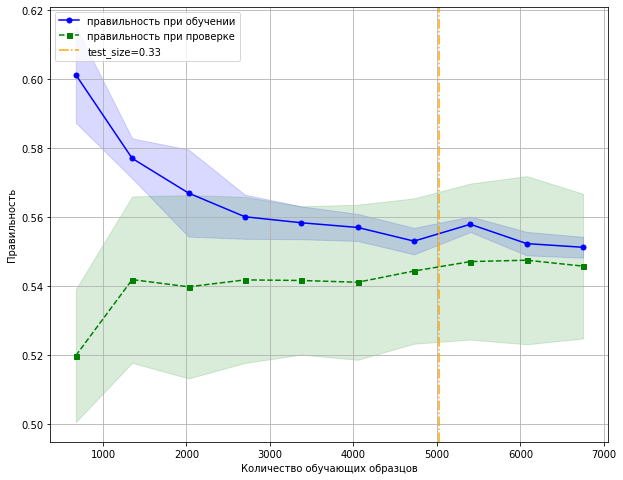

In [12]:
estimator = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1000.0, tol=1e-4, 
                        max_iter=200, class_weight='balanced'))
train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X, y=y, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, scoring='f1', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='правильность при обучении')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='правильность при проверке')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.axvline(X.shape[0]*0.67, color='orange', linestyle='-.', label='test_size=0.33')
plt.grid()
plt.xlabel('Количество обучающих образцов')
plt.ylabel('Правильность')
plt.legend(loc='best')
plt.show()
# оптимальный test_size=0.3

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)
X_train = custom_oversampling(pd.concat([X_train, y_train], axis=1))
y_train = X_train[TARGET_NAME]
X_train = X_train.drop(TARGET_NAME, axis=1)
X_train, y_train = preprocessor.sampling(pd.concat([X_train, y_train], axis=1), method='svm')

Inintial class labels ratio: {1: 2958, 0: 3771}
Final class labels ratio: {1: 3393, 0: 3771}


In [14]:
lr = LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1000.0, tol=1e-4, 
                        max_iter=200, class_weight='balanced')
selector = ChooseBestSubset(lr, k_features=15, test_size=0.3, custom=True, method='svm')
selector.fit(X, y)

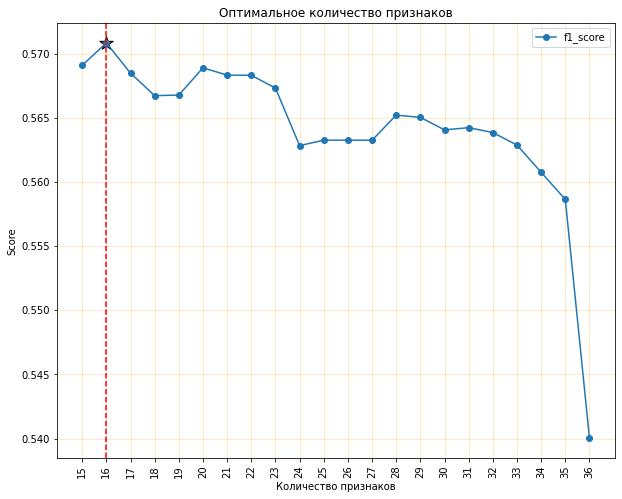

In [15]:
k_feat = [len(k) for k in selector.subsets_] # вычисляем длины наборов
plt.figure(figsize=(10, 8))
plt.plot(k_feat, selector.scores_, marker='o', label='f1_score')
plt.scatter(k_feat[np.argmax(np.array(selector.scores_))], max(selector.scores_), marker='*', color='red', 
              ec='black', s=200)
plt.axvline(k_feat[np.argmax(np.array(selector.scores_))], color='red', linestyle='--')
plt.title('Оптимальное количество признаков')
plt.ylabel('Score')
plt.xlabel('Количество признаков')
plt.xticks(k_feat, rotation=90)
plt.legend(loc='best')
plt.grid(color='orange', alpha=0.3) # из-за вывода матрицы корреляции с заданным стилем уходит сетка
plt.show()

In [16]:
indices = selector.subsets_[np.argmax(np.array(selector.scores_))]
Xs = X.values[:, indices]
Xs_train, Xs_test, ys_train, ys_test = X_train[:, indices], X_test.values[:, indices], y_train, y_test.values
s_scaler = StandardScaler()
Xs_train_std = s_scaler.fit_transform(Xs_train)
Xs_test_std = s_scaler.transform(Xs_test)

Base Estimator

In [17]:
clf1 = LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1000.0, tol=1e-4, # C=1000.0
                          max_iter=200, class_weight='balanced')

In [18]:
clf1.fit(Xs_train_std, ys_train)
lr_train_pred = clf1.predict(Xs_train_std)
lr_test_pred = clf1.predict(Xs_test_std)

In [19]:
report(ys_train, lr_train_pred, ys_test, lr_test_pred)

Train
               precision    recall  f1-score   support

           0      0.689     0.720     0.704      3771
           1      0.672     0.638     0.655      3393

    accuracy                          0.681      7164
   macro avg      0.681     0.679     0.679      7164
weighted avg      0.681     0.681     0.681      7164

Test
               precision    recall  f1-score   support

           0      0.846     0.737     0.788      1616
           1      0.496     0.659     0.566       634

    accuracy                          0.715      2250
   macro avg      0.671     0.698     0.677      2250
weighted avg      0.748     0.715     0.725      2250

Train ROC_AUC: 0.679, Test ROC_AUC: 0.698
Train GINI: 0.358, Test GINI: 0.396
Confusion Matrix 
 col_0     0    1
row_0           
0      1191  425
1       216  418


Меры правильности перекрекстной оценки: [0.65224111 0.67065868 0.64094955 0.67634253 0.61370717 0.68759342
 0.65123457 0.61949686 0.64083458 0.66367713]
Точность перекретсной оценки: 0.652 +/- 0.023




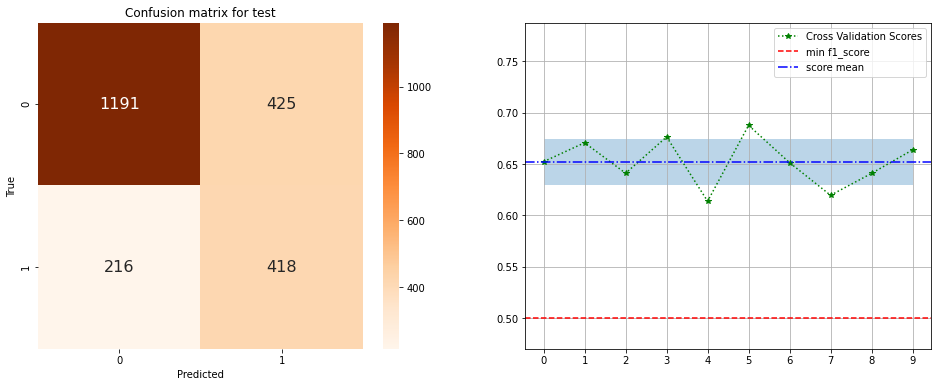

In [20]:
plot_cm_val(ys_test, lr_test_pred, Xs_train_std, ys_train, clf1)

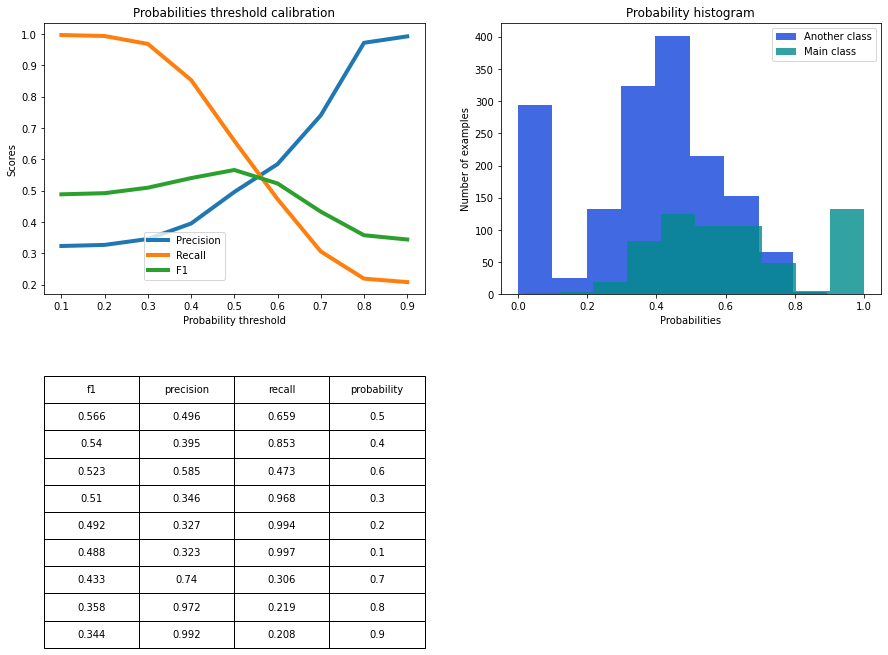

In [21]:
show_proba_calibration_plots(clf1.predict_proba(Xs_test_std)[:, 1], ys_test)

In [94]:
X_final = test_df.values[:, indices]
lr_final = clf1.predict(s_scaler.transform(X_final))

XGBoostClassifier

In [88]:
xgbc = XGBClassifier(max_depth=5, learning_rate=0.0001, n_estimators=350, n_jobs=-1, alpha=1e-4, 
                     scale_pos_weight=1.2,
                     gamma=1.1, random_state=1, seed=1, subsample=0.05, colsample_bytree=.8, silent=1,
                     tree_method='hist') 


In [89]:
xgbc.fit(Xs_train, ys_train)
x_train_pred = xgbc.predict(Xs_train)
x_test_pred = xgbc.predict(Xs_test)
report(ys_train, x_train_pred, ys_test, x_test_pred)

Train
               precision    recall  f1-score   support

           0      0.703     0.748     0.725      3771
           1      0.699     0.649     0.673      3393

    accuracy                          0.701      7164
   macro avg      0.701     0.699     0.699      7164
weighted avg      0.701     0.701     0.700      7164

Test
               precision    recall  f1-score   support

           0      0.836     0.749     0.790      1616
           1      0.494     0.625     0.552       634

    accuracy                          0.714      2250
   macro avg      0.665     0.687     0.671      2250
weighted avg      0.739     0.714     0.723      2250

Train ROC_AUC: 0.699, Test ROC_AUC: 0.687
Train GINI: 0.397, Test GINI: 0.373
Confusion Matrix 
 col_0     0    1
row_0           
0      1210  406
1       238  396


Меры правильности перекрекстной оценки: [0.63399694 0.67567568 0.64360902 0.69265367 0.6554878  0.68621701
 0.65653495 0.64759036 0.65481481 0.66666667]
Точность перекретсной оценки: 0.661 +/- 0.018




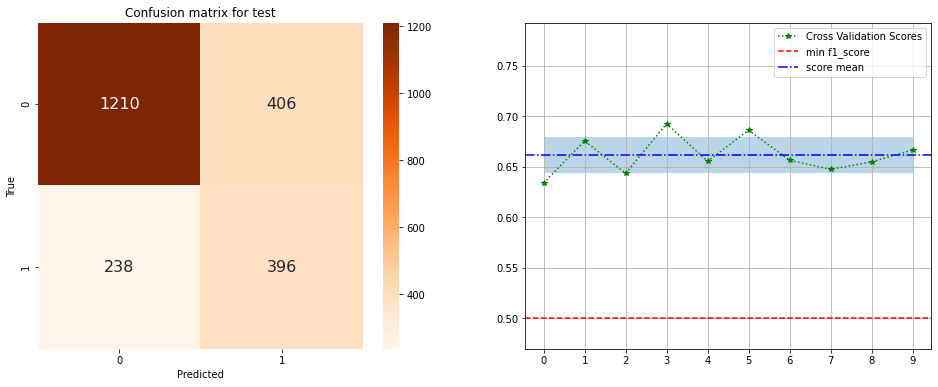

In [90]:
plot_cm_val(ys_test, x_test_pred, Xs_train, ys_train, xgbc)

In [92]:
x_final = xgbc.predict(test_df.values[:, indices])

array([1586,  914])

In [ ]:
# CatBoostClassifier

In [96]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
preprocessor = CatPreprocessor(with_cat=True)
train_df = preprocessor(train_df)
test_df = preprocessor(test_df)
X, y = train_df.drop([TARGET_NAME, 'CurLoan_cat', 'Ann_inc_cat'], axis=1), train_df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)

Score R2 [Credit Score]: {'learn': {'R2': 0.9790038153020464, 'RMSE': 4.04001804065672}, 'validation': {'R2': 0.9856249862055158, 'RMSE': 3.369283138967632}}
Score R2 [Annual Income]: {'learn': {'R2': 0.9912583171345436, 'RMSE': 76600.48705373169}, 'validation': {'R2': 0.9553670318733779, 'RMSE': 189225.51393705723}}
Memory usage of dataframe is 1.23 MB
Memory usage after optimization is: 0.48 MB
Decreased by 60.9%
Possible 8 outliers left, check dataset or use outlier stable methods
Memory usage of dataframe is 0.39 MB
Memory usage after optimization is: 0.16 MB
Decreased by 59.3%
Possible 5 outliers left, check dataset or use outlier stable methods


In [97]:
categorical_cols = train_df.select_dtypes(['category', 'int8']).columns.drop([TARGET_NAME, 'Ann_inc_cat', 'CurLoan_cat']).to_list()

In [98]:
""" custom oversampling, best score: f1 = 0.572, GINI = 0.406""" 
X_train = custom_oversampling(pd.concat([X_train, y_train], axis=1))
y_train = X_train[TARGET_NAME]
X_train = X_train.drop(TARGET_NAME, axis=1)

""" SMOTENC generative oversampling """
idx = [i for i, col in enumerate(X_train.columns) if col in categorical_cols]
over = SMOTENC(categorical_features=idx, random_state=1, n_jobs=-1, sampling_strategy=0.9)
X_train, y_train = over.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=X_test.columns)
y_train = pd.DataFrame(y_train, columns=[TARGET_NAME])
print()

In [286]:
class CatBoostSubsets:
    def __init__(self, k_features, scoring='f1_score', test_size=0.3, random_state=1):
        self.scoring = str(scoring)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        if (self.scoring == 'f1_score') or (self.scoring == 'accuracy_score'):
            self.scoring = eval(self.scoring)
        else:
            raise ValueError(f'Метрика должна быть "f1_score" или "accuracy_score", дана: {self.scoring}')
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, stratify=y, shuffle=True,
                                                           random_state=self.random_state)

        X_train = custom_oversampling(pd.concat([X_train, y_train], axis=1))
        y_train = X_train[TARGET_NAME]
        X_train.drop(TARGET_NAME, axis=1, inplace=True)

        dim = X_train.shape[1]
        self.indices_ = list(range(dim))
        self.ignored_indices_ = []
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.ignored_indices_) 
        self.scores_ = [score]
        while dim > self.k_features: 
            scores, subsets = [], []
            sys.stderr.write(f'Анализ наборов признаков {dim}/{X_train.shape[1]}, осталось {dim - self.k_features}:')
            for p in tqdm(combinations(self.indices_, r=dim-1), total=dim): 
                ignored_indices = list(set(self.indices_) - set(p))
                score = self._calc_score(X_train, y_train, X_test, y_test, ignored_indices)
                scores.append(score) 
                subsets.append(p) 
            clear_output(wait=True)
            best = np.argmax(scores) 
            self.indices_ = subsets[best] 
            self.subsets_.append(self.indices_) 
            dim -= 1
            self.scores_.append(scores[best]) 
        return self
    def _calc_score(self, X_train, y_train, X_test, y_test, ignored_indices): 
        params_model = {
                  'eval_metric': 'F1',
                  'auto_class_weights': 'Balanced',
                  'silent': True,
                  'one_hot_max_size': 15,
                  'early_stopping_rounds': 30,
                  'boosting_type': 'Ordered',
                  'allow_writing_files': False,
                  'depth': 5,
                  'learning_rate': 0.03,
                  'iterations': 200,
                  'l2_leaf_reg': 3.5,
                  'bagging_temperature': 2. }
        categorical_cols = X_train.select_dtypes(['category', 'int8']).columns.to_list()
        train_pool = Pool(X_train, y_train, cat_features=categorical_cols)
        test_pool = Pool(X_test, y_test, cat_features=categorical_cols)
        catboost = CatBoostClassifier(**params_model, ignored_features=ignored_indices)
        catboost.fit(train_pool, eval_set=test_pool)
        y_pred = catboost.predict(X_test)
        score = self.scoring(y_test, y_pred)
        return score

Подбор признаков не дает значительного преимущества, не запускайте в целях экономии времени

In [287]:
selector = CatBoostSubsets(random_state=1, k_features=15)
selector.fit(X, y)

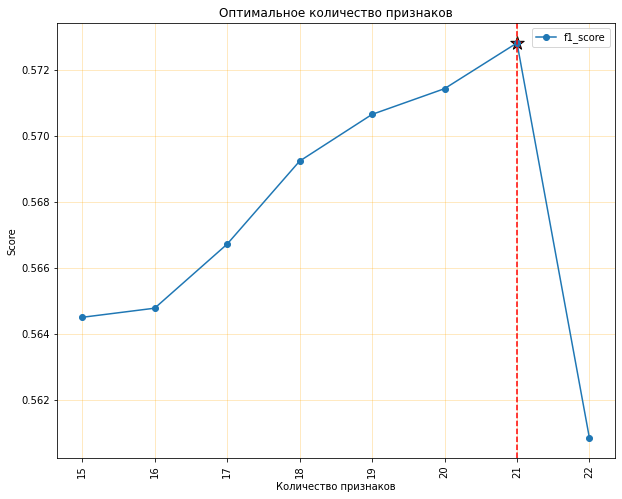

In [288]:
k_feat = [len(k) for k in selector.subsets_] # вычисляем длины наборов
plt.figure(figsize=(10, 8))
plt.plot(k_feat, selector.scores_, marker='o', label='f1_score')
plt.scatter(k_feat[np.argmax(np.array(selector.scores_))], max(selector.scores_), marker='*', color='red', 
              ec='black', s=200)
plt.axvline(k_feat[np.argmax(np.array(selector.scores_))], color='red', linestyle='--')
plt.title('Оптимальное количество признаков')
plt.ylabel('Score')
plt.xlabel('Количество признаков')
plt.xticks(k_feat, rotation=90)
plt.legend(loc='best')
plt.grid(color='orange', alpha=0.3) # из-за вывода матрицы корреляции с заданным стилем уходит сетка
plt.show()

In [294]:
# index to drop if it is single
index_to_drop = tuple(set(np.arange(X_train.shape[1])) - set(selector.subsets_[np.argmax(np.array(selector.scores_))]))
for idx in index_to_drop:
  X_train = X_train.drop(X_train.columns[idx], axis=1)
  X_test = X_test.drop(X_test.columns[idx], axis=1)

In [297]:
# do not forget to check categorical_cols on actual columns after selector

In [99]:
train_pool = Pool(X_train, y_train, cat_features=categorical_cols)

test_pool = Pool(X_test, y_test, cat_features=categorical_cols) 

params_model = {
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 15,
    'early_stopping_rounds': 30,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

In [100]:
catboost = CatBoostClassifier(**params_model)

params_grid = {
    'depth': [4, 5, 6, 7],
    'learning_rate': [0.03, 0.1, 0.3, 0.5],
    'iterations': [100, 200, 400],
    'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
    'bagging_temperature': [1, 1.5, 2]
}

gs = catboost.randomized_search(params_grid, train_pool, n_iter=20, shuffle=True, stratified=True,
                                 partition_random_seed=1, cv=5)

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6852656482
bestIteration = 2

0:	loss: 0.6852656	best: 0.6852656 (0)	total: 395ms	remaining: 7.5s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6887186825
bestIteration = 0

1:	loss: 0.6887187	best: 0.6887187 (1)	total: 872ms	remaining: 7.84s

bestTest = 0.7273806078
bestIteration = 98

2:	loss: 0.7273806	best: 0.7273806 (2)	total: 3.36s	remaining: 19.1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7122076208
bestIteration = 163

3:	loss: 0.7122076	best: 0.7273806 (2)	total: 7.72s	remaining: 30.9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6790850189
bestIteration = 1

4:	loss: 0.6790850	best: 0.7273806 (2)	total: 8.78s	remaining: 26.4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7536920656
bestIteration = 118

5:	loss: 0.7536921	best: 0.7536921 (5)	total: 14.1s	remaining: 32.9s
Stopped by overfitting detector  (30 iterations 

In [101]:
gs['params']

{'bagging_temperature': 2,
 'depth': 7,
 'iterations': 400,
 'l2_leaf_reg': 2,
 'learning_rate': 0.3}

In [108]:
catboost = CatBoostClassifier(**params_model, depth=7, iterations=400, learning_rate=0.03, l2_leaf_reg=2.,
                              bagging_temperature=2.)
# make handy finetune lr...
catboost.fit(train_pool, eval_set=test_pool)

In [109]:
cat_train_pred = catboost.predict(train_pool)
cat_test_pred = catboost.predict(test_pool)
report(y_train, cat_train_pred, y_test, cat_test_pred)

Train
               precision    recall  f1-score   support

           0      0.750     0.769     0.759      3771
           1      0.736     0.715     0.725      3393

    accuracy                          0.743      7164
   macro avg      0.743     0.742     0.742      7164
weighted avg      0.743     0.743     0.743      7164

Test
               precision    recall  f1-score   support

           0      0.851     0.754     0.799      1616
           1      0.513     0.662     0.579       634

    accuracy                          0.728      2250
   macro avg      0.682     0.708     0.689      2250
weighted avg      0.756     0.728     0.737      2250

Train ROC_AUC: 0.742, Test ROC_AUC: 0.708
Train GINI: 0.484, Test GINI: 0.416
Confusion Matrix 
 col_0              0    1
Credit Default           
0               1218  398
1                214  420


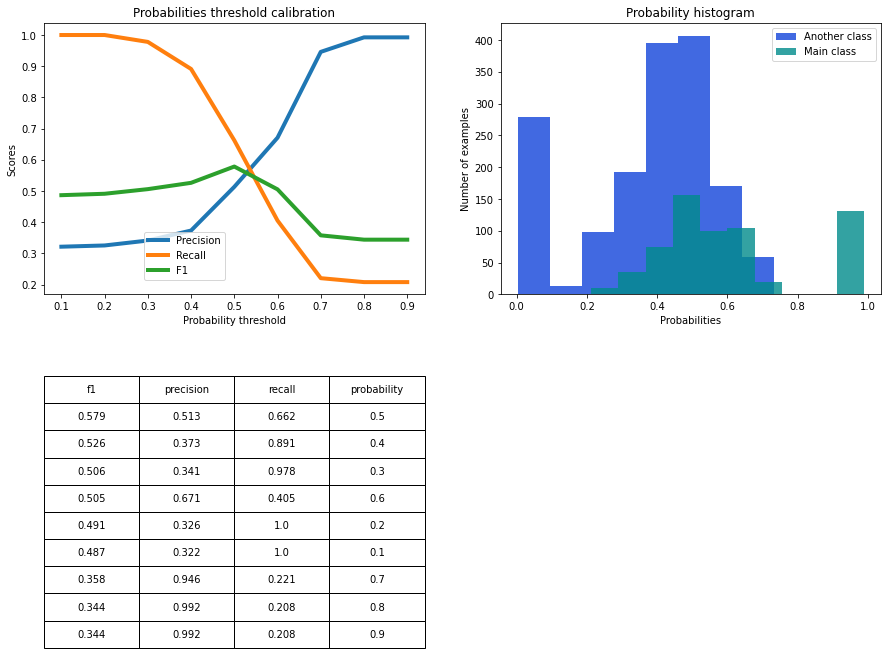

In [110]:
show_proba_calibration_plots(catboost.predict_proba(X_test)[:, 1], y_test)

In [111]:
 # for best recall
probs = catboost.predict_proba(X_test)
preds = np.where(np.max(probs, axis=1) >= 0.1, 1, 0) # argmax
preds

array([0, 0, 0, ..., 1, 1, 1])

1) isSusp	78.6889925484116
2) Credit Score	3.3584387952456716
3) Term	2.6615085723524827
4) Cs_cat	1.8504194287329203
5) Month_ratio	1.794460264309246
6) Maximum Open Credit	1.6321308959024694
7) isNa	1.5345665687753265
8) Years in current job	1.2043448846678673
9) Home Ownership	1.1306138562994426
10) Annual Income	1.030810981655795
11) Current Loan Amount	0.8144700266622318
12) Max_Acc	0.7807165193906037
13) Current Credit Balance	0.6543631561366563
14) Months since last delinquent	0.527527915367342
15) Years of Credit History	0.47903712424861195
16) Monthly Debt	0.4194898026094312
17) Number of Open Accounts	0.33881753416473187
18) Number of Credit Problems	0.33244612171529864
19) Purpose	0.32136198698195334
20) Tax Liens	0.23140682298267232
21) Bankruptcies	0.1266989587718902
22) Cluster	0.08737723461572675


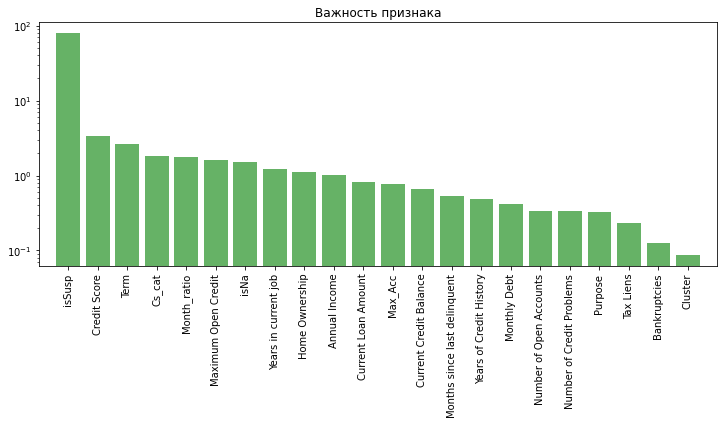

In [112]:
feat_labels = X_train.columns
importances = catboost.get_feature_importance()
indices = np.argsort(importances)[::-1]
for x in range(X_train.shape[1]):
    print(f'{x+1}) {feat_labels[indices[x]]}\t{importances[indices[x]]}')
plt.figure(figsize=(10, 6))
plt.title('Важность признака')
plt.bar(range(X_train.shape[1]), importances[indices], align='center', alpha=0.6, color='green')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.yscale('log')
plt.show()

In [113]:
cat_final = catboost.predict(test_df.drop(['Ann_inc_cat', 'CurLoan_cat'], axis=1)) 

array([1586,  914])

In [114]:
# LightGBM

In [116]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
preprocessor = CatPreprocessor(with_cat=True) # try without cat
train_df = preprocessor(train_df)
test_df = preprocessor(test_df)
X, y = train_df.drop([TARGET_NAME,], axis=1), train_df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)

Score R2 [Credit Score]: {'learn': {'R2': 0.9789034893025714, 'RMSE': 4.049658740230643}, 'validation': {'R2': 0.9857079981999899, 'RMSE': 3.3595406833035346}}
Score R2 [Annual Income]: {'learn': {'R2': 0.991852695180869, 'RMSE': 73950.47878344296}, 'validation': {'R2': 0.9611620663259729, 'RMSE': 176514.2887005666}}
Memory usage of dataframe is 1.23 MB
Memory usage after optimization is: 0.48 MB
Decreased by 60.9%
Possible 8 outliers left, check dataset or use outlier stable methods
Memory usage of dataframe is 0.39 MB
Memory usage after optimization is: 0.16 MB
Decreased by 59.3%
Possible 4 outliers left, check dataset or use outlier stable methods


In [117]:
X_train = custom_oversampling(pd.concat([X_train, y_train], axis=1))
y_train = X_train[TARGET_NAME]
X_train = X_train.drop(TARGET_NAME, axis=1)

In [118]:
categorical_cols_str = (',').join([str(i) for i, col in enumerate(X_train.columns) if col in categorical_cols])

In [227]:
# Grid Search

In [187]:
lgbm = LGBMClassifier(learning_rate=0.008, max_depth=6, num_leaves=35, min_data_in_leaf=5, lambda_l2=100., 
                      metric='f1', categorical_feature=categorical_cols_str, is_unbalance=True,
                      feature_fraction=.7, bagging_fraction=.1, num_iterations=500, 
                      seed=1, boosting='goss')

In [188]:
lgbm.fit(X_train, y_train)
l_train_pred = lgbm.predict(X_train)
l_test_pred = lgbm.predict(X_test)
report(y_train, l_train_pred, y_test, l_test_pred)

Train
               precision    recall  f1-score   support

           0      0.789     0.743     0.766      3771
           1      0.695     0.747     0.720      2958

    accuracy                          0.745      6729
   macro avg      0.742     0.745     0.743      6729
weighted avg      0.748     0.745     0.746      6729

Test
               precision    recall  f1-score   support

           0      0.846     0.723     0.780      1616
           1      0.486     0.666     0.562       634

    accuracy                          0.707      2250
   macro avg      0.666     0.695     0.671      2250
weighted avg      0.745     0.707     0.719      2250

Train ROC_AUC: 0.745, Test ROC_AUC: 0.695
Train GINI: 0.490, Test GINI: 0.389
Confusion Matrix 
 col_0              0    1
Credit Default           
0               1169  447
1                212  422


In [189]:
light_final = lgbm.predict(test_df)

array([1522,  978])

In [210]:
""" best f1_score for voting 0.578, GINI 0.416 """
major_test = vote([lr_test_pred, x_test_pred, cat_test_pred, l_test_pred], weights=[1.8, 1.5, 2.5, 1.5])
print(classification_report(major_test, y_test, digits=3))
print('Confusion Matrix', '\n', pd.crosstab(y_test, major_test))
print(f'ROC_AUC: {roc_auc_score(y_test, major_test):.3f}, GINI: {(2*roc_auc_score(y_test, major_test)-1):.3f}')

              precision    recall  f1-score   support

           0      0.749     0.852     0.797      1421
           1      0.667     0.510     0.578       829

    accuracy                          0.726      2250
   macro avg      0.708     0.681     0.688      2250
weighted avg      0.719     0.726     0.716      2250

Confusion Matrix 
 col_0              0    1
Credit Default           
0               1210  406
1                211  423
ROC_AUC: 0.708, GINI: 0.416


In [205]:
submission_vote = vote([lr_final, x_final, cat_final, light_final], weights=[1.8, 1.5, 2.5, 1.5])

In [208]:
Sub_df = pd.DataFrame(np.stack((np.arange(test_df.shape[0]), submission_vote), axis=1), columns=['Id', 'Credit Default'])
Sub_df.to_csv('/content/drive/My Drive/data/default_set/final_submission.csv', index=False, encoding='utf-8')
Sub_df.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1


FINAL SUBMISSION: The private leaderboard is calculated with approximately 70% of the test data.

This competition has completed. This leaderboard reflects the final standings. - my result: 0.55929